In [1]:
%run Latex_macros.ipynb
%run beautify_plots.py

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import svm, pipeline
from sklearn.preprocessing import PolynomialFeatures

import training_models_helper as tmh
%aimport training_models_helper

tm = tmh.TrainingModelsHelper()

import svm_helper
%aimport svm_helper
svmh = svm_helper.SVM_Helper()

kn = tmh.KNN_Helper()

import transform_helper
%aimport transform_helper

th = transform_helper.Transformation_Helper()

iph = transform_helper.InfluentialPoints_Helper()

import svm_helper
%aimport svm_helper
svmh = svm_helper.SVM_Helper()

import class_helper
%aimport class_helper


# Transformation to add a "missing" numeric feature

Sometimes our models can't fit the data because some key feature is missing.

This was the case for our "curvy" data and Linear model: the polynomial term was missing.

The model
$$ \y = \Theta_0 + \Theta_1 * \x_1$$
was not a good match for the data, but
$$ \y = \Theta_0 + \Theta_1 * \x_1 + \Theta_2* \x_1^2$$
was a much better fit.

Both models are linear, but the linearity of the relationship between target and features
did not become clear until the missing feature $\x_1^2$ was added.

An identical transformation works for a Classification task:


By adding polynomial features
- We achieve separability
- The separating boundary is linear in *transformed features*
- But clearly not linear in raw features

In [4]:
svmh = svm_helper.SVM_Helper()

_= svmh.create_kernel_data()

gamma=1
C=0.1

linear_kernel_svm = svm.SVC(kernel="linear", gamma=gamma)

# Pipelines
feature_map_poly2 = PolynomialFeatures(2)
poly2_approx = pipeline.Pipeline( [ ("feature map", feature_map_poly2),
                                    ("svm", svm.LinearSVC())                 
                                  ])

classifiers =  [ ("SVC", linear_kernel_svm),
                ("poly (d=2) transform + SVC", poly2_approx)
               ]
_= svmh.create_kernel_data(classifiers=classifiers)      
fig, axs = svmh.plot_kernel_vs_transform()
plt.close()

/home/kjp/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


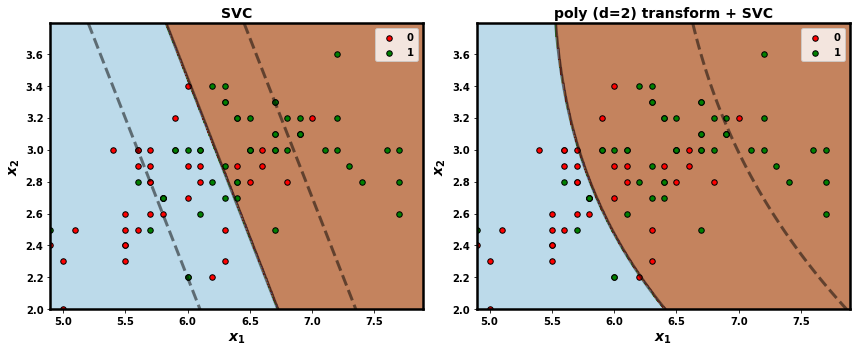

In [5]:
fig

- Left plot shows a boundary that is linear in raw features
- Right plot show a boundary that is linear in transformed features
    - plotted in the dimensions of raw features

The transformation results in a boundary shape with greater flexibility.

Here is another common transformation that adds a feature to facilitate linear separability.

Consider the follow examples
- Which, to the eye, are separable
- But are not linearly separable

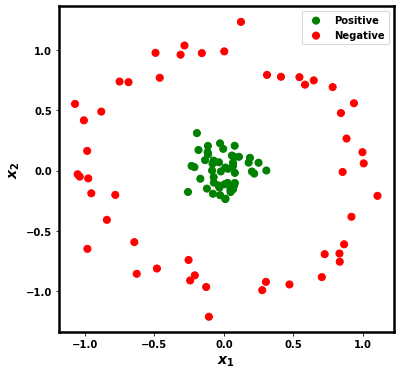

In [6]:
fig, ax = plt.subplots(1,1, figsize=(6,6) )
Xc, yc = svmh.make_circles(ax=ax, plot=True)

Visually, we can see that the classes are separable, but clearly not by a line.

Here's what one linear classifier (an SVC, which we will study later) produces

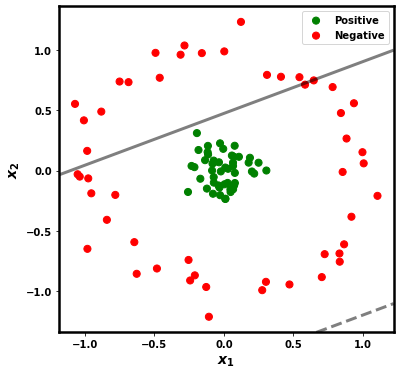

In [7]:
fig, ax = plt.subplots(1,1, figsize=(6,6) )
svm_clf = svmh.circles_linear(Xc, yc, ax=ax)

Let's add a new feature defined by the (Gaussian) *Radial Basis Function (RBF)*
$$
\x_3 = e^{ - \sum_j { \x_j^2 } }
$$

Our features are now 3 dimensional; let's look at the plot:

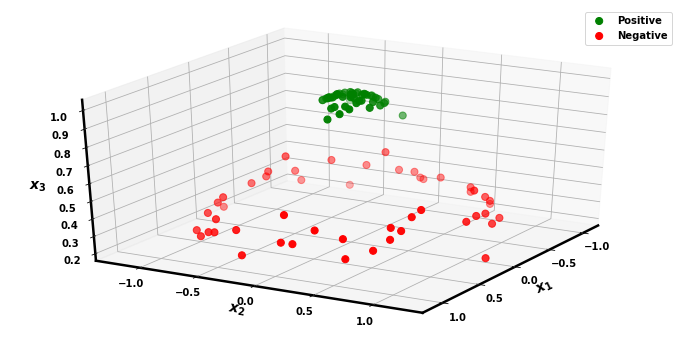

In [8]:
X_w_rbf = svmh.circles_rbf_transform(Xc)
_= svmh.plot_3D(X=X_w_rbf, y=yc )

Magic ! The new feature enables a plane that is parallel to the $\x_1, \x_2$ plane to separate the two classes.

We can write the RBF transformation in a more general form:
$$
\text{RBF}(\x) = e^{ - || \x - \x_c || }
$$

- $|| \x - \x_c ||$ is a measure of the distance between example $\x$ and reference point $\x_c$
- In our case
    - $|| \x - \x_c ||$ is the L2 (Euclidean) distance
    - $\x_c$ is the origin $(0, 0)$

There is an even simpler transformation we could have used.

$$ 
\x_3 = - \sum_j { \x_j^2 } 
$$

That is: the (negative) of the L2 distance.

The advantage of the RBF is that it has little effect on points far from the reference point.

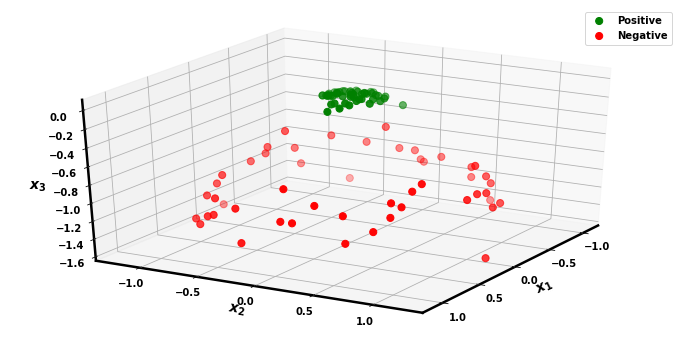

In [9]:
X_w_rad = svmh.circles_radius_transform(Xc)
_= svmh.plot_3D(X=X_w_rad, y=yc )

Although this transformation seems magical, we must be skeptical of magic
- There should be some *logical* justification for the added feature
- Without such logic: we are in danger of overfitting and will fail to generalize to test examples

For example:
- Perhaps $\x_1, \x_2$ are geographic coordinates (latitude/longitude)
- There is a distinction (different classes) based on distance from the city center $(\x_1, \x_2) = (0,0)$
    - e.g. Urban/Suburban


# Transformation to add a "missing" categorical feature

Here is a less obvious case of a missing feature.

Suppose we obtain examples
- At different points in time
- Or in distinct geographies

What we often observe is that the examples
- From the same time/same place are similar to one another
- From different times/places are quite different

That is: the data naturally partitions into self-similar "groups".

How do we pool data that is similar intra-group but different across groups ?

Here is an artificial data set (Price  as a function of Size) sampled at two different dates.

We will refer to the data at each date as a "group".

In [10]:
sph = transform_helper.ShiftedPrice_Helper()
series_over_time = sph.gen_data(m=30)

fig, ax = plt.subplots(1,1, figsize=(12,6) )
_= sph.plot_data(series_over_time, ax=ax)

plt.close(fig)

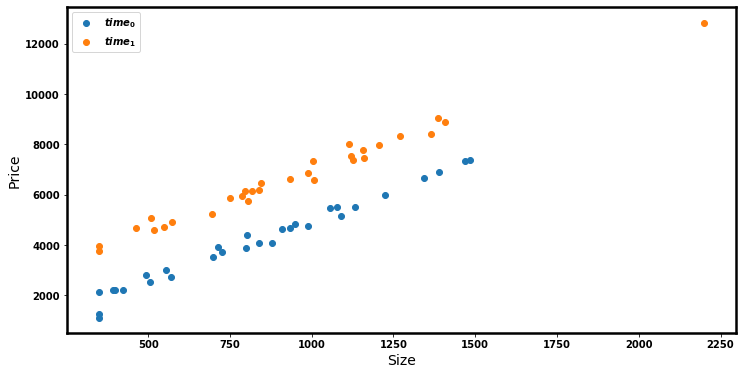

In [11]:
fig

It appears that
- The groups are defined by examples gathered at different times: $\text{time}_0, \text{time}_1$
- There is a linear relationship *in each group* in isolation
- There slope of the relationship is *the same* across time
- But the intercept differs across groups
    - Perhaps this reflects a tax or rebate that is independent of price.
    



If we are correct in hypothesizing that each group is from the same distribution *except for* different intercepts
- Here's a set of equations that describes the data (separately for each of the two groups):
$$
\begin{array}[lll]\\
\y_{(\text{time}_0)} & = & \Theta_{(\text{time}_0)} + \Theta_1 * \x \\
\y_{(\text{time}_1)} & = & \Theta_{(\text{time}_1)} + \Theta_1 * \x \\
\end{array}
$$

Trying to fit a line (Linear Regression) as a function of the combined data will be disappointing.

We can try a transformation that compensates for the different intercepts.

Consider the transformation 
- That adds a *categorical feature* `time` with two discrete values
- Encoded via OHE as two binary *indicators* 

$$
\text{Is}_j^\ip = 
\left\{
    {
    \begin{array}{lll}
     1 & \textrm{if } \x^\ip  \text{ is in group } j  &  \\
     0 & \textrm{if } \x^\ip  \text{ is NOT in group } j  &  \\
    \end{array}
    }
\right.
$$

For example:
- if example $i$ is from the time 0 group
$$
\begin{array}[lll]\\
\text{Is}_0^\ip = 1 \\
\text{Is}_1^\ip = 0 \\
\end{array}
$$

Because $\text{Is}_0 $ and $\text{Is}_1$ are complementary 
- The following single equation combines the two groups without losing the distinction

$$
\begin{array}[lll]\\
\y & = & \Theta_{(\text{time}_0)} * \text{Is}_0 + \Theta_{(\text{time}_1)} * \text{Is}_1  + \Theta_1 * \x \\
\end{array}
$$

Effectively, the equation allows each group to have its own intercept !

This is equivalent to 
- Fitting one line per group, with the same slope
- But different intercepts

Here's what the design matrix $\X''$ looks like when we add the two indicators:

$
  \X'' = \begin{pmatrix}
  \mathbf{Is}_0 & \mathbf{Is}_1  & \mathbf{other \; features}\\
  1 & 0  & \ldots \\ 
   0 & 1  & \ldots\\ 
   \vdots \\
  \end{pmatrix}
  \begin{matrix}\\
  \text{time}_0 \\
  \text{time}_1 \\
  \\
  \end{matrix}
$

- Examples from the first time period look similar to the first row
- Examples from the second time period look similar to the second row


Notice that there is no "constant" feature in the design matrix
- Would correspond to the "intercept" term in linear regression

The reason for this is
- We already have **two** intercept-like terms $\text{Is}_0$ and $\text{Is}_1$
- The constant feature would be equal to the sum of these two features, for each example
    - Creates *dummy variable* trap for Linear Regression
    

## Alternate method: non-homogeneous groups similar

Given our hypothesis that
$$
\begin{array}[lll]\\
\y_{(\text{time}_0)} & = & \Theta_{(\text{time}_0)} + \Theta_1 * \x \\
\y_{(\text{time}_1)} & = & \Theta_{(\text{time}_1)} + \Theta_1 * \x \\
\end{array}
$$
it would be natural to try to make the two groups appear similar by subtracting each group's intercept
term from each example's target.

Unfortunately: we don't know these intercept terms a priori.

Here is a simple trick.

If
$$
\begin{array} \\
\y^\ip & = & \Theta_0 + \Theta_1 * \x^\ip & \text{hypothesize linear relationship} \\
\frac{1}{m} \sum_i { \y^\ip } & =  &\frac{1}{m} \sum_i { (\Theta_0 + \Theta_1 * \x^\ip) } & \text{sum over all examples, divide by no. of examples }\\
\bar{\y} & = & \Theta_0 + \Theta_1 * \bar\x & \text{definition of average} \\
\Theta_0 = \bar\y - \Theta_1 * \bar\x & \text{re-arrange terms}
\end{array}
$$

This still doesn't allow us to know the value for $\Theta_0$ because we don't know $\Theta_1$ a priori.

But: if we demean each $\x^\ip$
$$
\x^\ip = \x^\ip - \bar\x
$$
then $\bar\x = 0$ and
$$
\Theta_0 = \bar\y
$$

So 
- if we demean the feature of each group separately
- we know the intercept for each group is the mean of the group's target
- we can make the two groups similar by subtracting the group mean from the target of each group

Here is a little code showing the effect

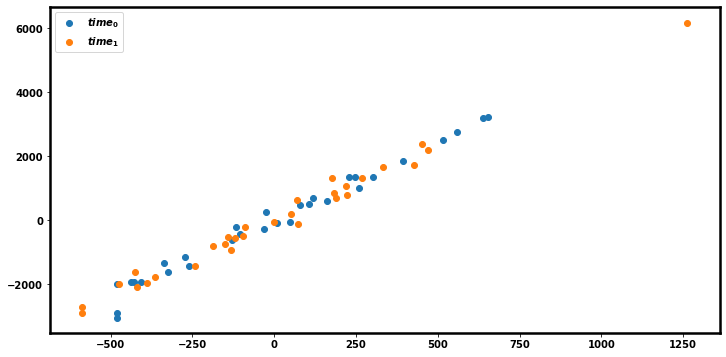

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12,6) )

demean_x0 = sph.x0 - sph.x0.mean()
demean_x1 = sph.x1 - sph.x1.mean()

_= ax.scatter(demean_x0, sph.y0 - sph.y0.mean(), label="$time_0$")
_= ax.scatter(demean_x1, sph.y1 - sph.y1.mean(), label="$time_1$")
_= ax.legend()

Now it looks like each group comes from the same distribution.
- We can pool the observations from the two groups

# Cross features

We have already seen a number of examples where adding a simple indicator succeeded in
making our data linearly separable.

Sometimes though, an indicator on a *single* feature won't suffice
- But a synthetic feature that is the *product* of indicators will
- Can indicate an example's presence in the *intersection* of two groups

A synthetic feature created by combining (multiplying) two or more simple features is called
a *cross term*

Let's revisit our circle classification dataset.

Here we create a cross feature that is `True` if two simpler features hold simultaneously
- $\x_1$ indicator: the horizontal offset from the origin $(0,0)$ is "small"
- $\x_2$ indicator: the vertical  offset from the origin $(0,0)$ is "small"

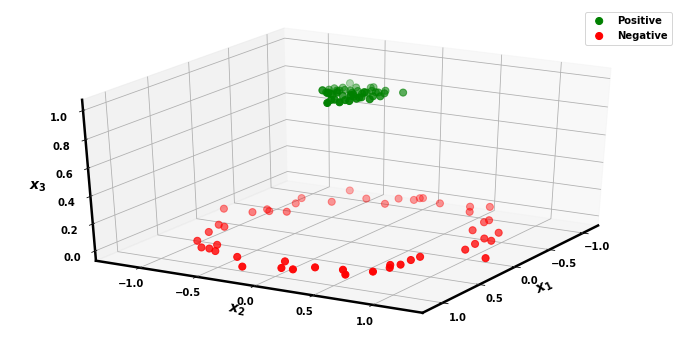

In [13]:
X_w_sq = svmh.circles_square_transform(Xc)
_= svmh.plot_3D(X=X_w_sq, y=yc )

Here's the code to create the new feature "r" as a cross term

We created a single "cross product" indicator $\text{Is}_{\text{in area}}$ as the product of two indicators, one per feature
    
$$
\begin{array}[lll]\\
\text{Is}_{\text{in } \x_1 \text{ range}} = (|\x_1| \le 0.5)\\
\text{Is}_{\text{in } \x_2 \text{ range}} = (|\x_2| \le 0.5)\\
\text{Is}_{\text{in area}} = \text{Is}_{\text{in $\x_1$ range}} * \text{Is}_{\text{in $\x_2$ range}} \\
\end{array}
$$

The *cross term* $\text{Is}_{\text{in area}}$ indicates being in the *intersection*
of $\text{Is}_{\text{in } \x_1 \text{ range}}$
and
$\text{Is}_{\text{in } \x_2 \text{ range}}$.

Note that only the single $\text{Is}_{\text{in area}}$ indicator is included in the equation
and design matrix $\X''$

The isolated indicators 
$$\text{Is}_{\text{in } \x_1 \text{ range}}, \text{Is}_{\text{in } \x_2 \text{ range}}$$
don't appear in the final regression equation -- they are used only to define $\text{Is}_{\text{in area}}$

Cross terms are very tempting but can be abused when over-used.

To illustrate potential for abuse, it is possible to
- Create *one indicator per example*
- Create a cross term of the example indicator with each parameter in $\Theta$
- This results in a completely separate set of parameters for *each* example
    - We "memorize" the data !

Here's a picture of the "per example" indicator

First, construct an indicator which is true
- if an example's feature $j$ value is equal to the feature $j$ value of example $i$:

$$
\text{Is}_{\x^\ip_j} = (\x_j = \x^\ip_j)
$$

Now construct a cross feature that combines the indicators for all $j$ and a single example $i$:
$$
\begin{array}[lll]\\
\text{Is}_{\text{example }i} & = & (\x_1 = \x_1^\ip) * (\x_2 = \x_2^\ip)\\
\end{array}
$$

This cross feature will be true on example $i$.

We can construct such a cross feature that recognizes any single example.

And here's the design matrix $\X''$ with a separate intercept per example.

$\X''$ has $m$ intercept columns, one for each example,
forming a diagonal of 1's

$
  \X'' = \begin{pmatrix}
  \mathbf{const} & \text{Is}_{\text{example 1}} & \text{Is}_{\text{example 2}} & \text{Is}_{\text{example 3}} & \ldots & \mathbf{other \; features}\\
  1 &  1 & 0  & 0 & \ldots \\ 
  1 &  0 & 1  & 0 & \ldots\\ 
  1 &  0 & 0  & 1 &\ldots\\ 
   \vdots \\
  \end{pmatrix}
$

We can do the same for $\Theta_1, \Theta_2, \ldots, \Theta_n$
resulting in a design matrix $\X''$ with $m * n$ indicators
- One per example per parameter


Here's a design matrix $\X''$ with one set of parameters per example:
\
$
  \X'' = \begin{pmatrix}
  \mathbf{const} & \text{Is}_{\text{example 1}} & (\text{Is}_{\text{example 1}} *\x_1) & (\text{Is}_{\text{example 1}} * \x_2) & \ldots & \text{Is}_{\text{example 2}} & (\text{Is}_{\text{example 2}} *\x_1) & (\text{Is}_{\text{example 2}} * \x_2) & \ldots\\
  1 &  1 & \x^{(1)}_1  & \x^{(1)}_2 & \ldots & 0 & 0 & 0\\ 
  1 &  0 & 0          & 0         & \ldots  &  1 & \x^{(2)}_1  & \x^{(2)}_2 \\  
   \vdots \\
  \end{pmatrix}
$

Using this as the design matrix in Linear Regression
- Will get a perfect fit to training examples
- Would likely **not generalize** well to out of sample test examples.

When truly justified a small number of complex cross terms are quite powerful.

In [14]:
print("Done")

Done
